# Tennis with MADDPG

In this project we have created two tennis-playing agents that are trained via Multi-Agent Deep Deterministic Policy (MADDPG). The implementation is derived from the solution to a previous Udacity Deep Reinforcement Learning Nanodegree exercise in which a MADDPG is used to train agents to play the Physical Deception problem. See https://arxiv.org/pdf/1706.02275.pdf for the paper introducing MADDPG.

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

In this project the agent's learning algorithm is Multi-Agent Deep Deterministic Policy (MADDPG). The MADDPG meta-agent manages multiple DDPG agents, each with two actor networks (local and target) and two critic networks (local and target). The full observation set (plus actions from all agents) is provided to all critic networks for training, but each agent's actor receives only the observations pertaining to that agent.

In MADDPG, training is performed by running episodes and storing each step in a replay buffer. The training then iterates over batches of samples randomly drawn from the replay buffer, optimizing both actor and critic networks. 

A simple neural network architecture is used for both actors and critics. For the actors, the NNs consist of:
- two fully-connected hidden layers with ReLU activation and dropout (three hidden layers were also tried)
- a fully-connected output layer of size corresponding to the number of actions (in this case, two: movement and jumping) with tanh activation which limits its output to the action space

For the critics, the NNs consist of:
- four fully-connected hidden layers with ReLU activation and dropout (two and three hidden layers were also tried)
- a fully-connected output layer with a single unit (and no activation function) estimating the Q of the input values

The weights for both actor and critic networks (local copy) are updated using Adam optimizers, and the target instances of each are updated from the local copies via soft updates.

The hyperparameter values used were:

```python
hidden_in_actor = 256
hidden_out_actor = 128
hidden_in_critic = 256
hidden_out_critic = 128
lr_actor = 5e-4
lr_critic = 1e-3
dropout = 0.3

batchsize = 512  # Also tried 1024
maddpg_train.REPLAY_BUFFER_LEN = 1_000_000
episode_length = 200
episodes_per_update = 8
discount_factor = 0.99  # gamma
tau = 1e-3
ou_noise = 4.0
noise_reduction = 0.9999
```

## Code Structure

### networkforall.py

`networkforall.py` has the PyTorch deep neural network model that implements both the actor and critic neural networks.

### ddpg_agent.py

`ddpg_agent.py` provides the per-agent logic around the neural network. It creates four instances of the NN from networkforall.py: two actor networks (local and target), and two critic networks (local and target). Its interface methods include:
- act(): given observations for this agent, return the selected action based on the local policy, optionally with OU noise added
- target_act(): given observations for this agent, return the selected action based on the target policy, optionally with OU noise added

### maddpg_agent.py

`maddpg_agent.py`'s MADDPG_Agent class manages the MADDPG algorithm. It keeps an instance of DDPGAgent for each agent. Methods include
- act(): return the results of each agent's act()
- target_act(): return the results of each agent's target_act
- update(): update actor and critic networks of all agents (local networks, not target networks)
- update_targets(): soft-update actor and critic target networks of all agents

### maddpg_train.py

`maddpg_train.py` manages the MADDPG training. It runs the desired number of training episodes (stopping early if the goal is reached):
- Execute an entire episode, storing each step in the replay buffer
- Draw a random sample from the replay buffer
- Update the MADDPG agent

### run.py

Although the primary interactive method for working with this algorithm is the `Tennis.ipynb` notebook, `run.py` allows repeated runs of the algorithm using randomly chosen hyperparameters. This was used to try dozens of hyperparameter combinations looking for a set that would provide better results.

## Sample Plot of Training Rewards

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from maddpg_train import GOAL_WINDOW_LEN
with open('score_history.txt') as fp:
    mean_rewards = [float(x) for x in fp.read().splitlines()]
print('Environment solved in {:d} episodes!'.format(len(mean_rewards) - GOAL_WINDOW_LEN))

Environment solved in 9900 episodes!


### Not yet solved...

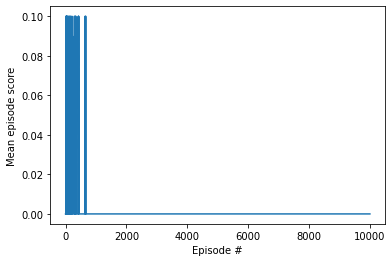

In [3]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
plt.ylabel('Mean episode score')
plt.xlabel('Episode #')
plt.show()

## Tensorboard Graphs

Tensorboard graphs showing per-agent losses and per-agent moving-average rewards:

![](tensorboard2.png)

## Ideas for Future Work

The preferred first action for future work would be to get this to actually learn. I have already tried many combinations of hyperparameters, changes to weight initialization, batch normalization, both SmoothL1Loss and MSELoss, dropout, a varied number of hidden actor and critic network layers, providing all observations to all agent actors instead of just that agent's observations, and critic gradient clipping.

Once the project shows evidence of the ability to learn, other areas in which to search for improvement include:
- properly optimizing the hyperparameters and neural network architecture
- prioritized experience replay in order to learn more efficiently
- the MADDPG paper mentions the use of entropy regularization which could be explored
- the MADDPG paper describes an option for policy ensembles in which agents have multiple subpolicies to help with environment non-stationarity; the paper suggests this is most helpful in competitive environments, which this is not, but it would still be interesting to try